In [1]:
import os
os.getcwd()

'C:\\Users\\us16120\\Projects\\Cheminformatyka\\workflows'

In [2]:
import pandas as pd
import numpy as np
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from tqdm.notebook import tqdm, tnrange
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from glob import glob
import seaborn as sns
from rdkit.Chem import rdMolDescriptors

Read data

In [3]:
# df = PandasTools.LoadSDF("../data/JCIM_59_1269/HERG.sdf")
# df.columns

Morgan fingerprint >> numpy array

In [4]:
# ECFP4-like

def ecfp_as_array(mol, length = 2):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, length, nBits = 1024)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [5]:
# FCFP4-like

def fcfp_as_array(mol, length = 2):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, length, useFeatures = True, nBits = 1024)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [6]:
# Topological Torsions

def topo_as_array(mol):
    fp = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits = 1024)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [7]:
# Atom Pairs

def ap_as_array(mol):
    fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits = 1024)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [8]:
# MACCS

def maccs(mol):
    fp = MACCSkeys.GenMACCSKeys(mol)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

Build dataframe

In [9]:
def build_dataframe(input_file_name):
    df = PandasTools.LoadSDF(input_file_name)
    df['pIC50'] = [float(x) for x in df.pIC50]
    df['ecfp'] = [ecfp_as_array(x, 2) for x in df.ROMol]
    df['fcfp'] = [fcfp_as_array(x, 2) for x in df.ROMol]
    df['topo'] = [topo_as_array(x) for x in df.ROMol]
    df['ap'] = [ap_as_array(x) for x in df.ROMol]
    df['maccs'] = [maccs(x) for x in df.ROMol]
    return df

In [10]:
qaz = build_dataframe("HERG.sdf")

Benchmark

In [11]:
def benchmark_dataset(df, name, cv_folds = 10):
    ecfp_list = []
    fcfp_list = []
    topo_list = []
    ap_list = []
    maccs_list = []
    
    for i in tnrange(cv_folds, desc=name):
        
        train, test = train_test_split(df)
        
        ecfp_xgb = XGBRegressor()
        ecfp_xgb.fit(np.array([x for x in train.ecfp.values]), train.pIC50)
        ecfp_pred = ecfp_xgb.predict(np.array([x for x in test.ecfp.values]))        
        ecfp_r2 = r2_score(test.pIC50, ecfp_pred)  
        ecfp_list.append(ecfp_r2)
        
        fcfp_xgb = XGBRegressor()
        fcfp_xgb.fit(np.array([x for x in train.fcfp.values]), train.pIC50)
        fcfp_pred = fcfp_xgb.predict(np.array([x for x in test.fcfp.values]))        
        fcfp_r2 = r2_score(test.pIC50, fcfp_pred)  
        fcfp_list.append(fcfp_r2)
        
        topo_xgb = XGBRegressor()
        topo_xgb.fit(np.array([x for x in train.topo.values]), train.pIC50)
        topo_pred = topo_xgb.predict(np.array([x for x in test.topo.values]))        
        topo_r2 = r2_score(test.pIC50, topo_pred)  
        topo_list.append(topo_r2)
        
        ap_xgb = XGBRegressor()
        ap_xgb.fit(np.array([x for x in train.ap.values]), train.pIC50)
        ap_pred = ap_xgb.predict(np.array([x for x in test.ap.values]))        
        ap_r2 = r2_score(test.pIC50, ap_pred)  
        ap_list.append(ap_r2)
        
        maccs_xgb = XGBRegressor()
        maccs_xgb.fit(np.array([x for x in train.maccs.values]), train.pIC50)
        maccs_pred = maccs_xgb.predict(np.array([x for x in test.maccs.values]))        
        maccs_r2 = r2_score(test.pIC50, maccs_pred)  
        maccs_list.append(maccs_r2)
        
    return np.array(ecfp_list), np.array(fcfp_list), np.array(topo_list), np.array(ap_list), np.array(maccs_list)

In [12]:
def run_benchmarks(file_spec):
    result_list = []
    for filename in glob(file_spec):
        df = build_dataframe(filename)
        name = filename.replace(".sdf","")
        ecfp_res, fcfp_res, topo_res, ap_res, maccs_res = benchmark_dataset(df, name)
        for ecfp, fcfp, topo, ap, maccs in zip(ecfp_res, fcfp_res, topo_res, ap_res, maccs_res):
            result_list.append([name, ecfp, fcfp, topo, ap, maccs])
    return result_list

In [13]:
%time result_list = run_benchmarks("../data/JCIM_59_1269/*.sdf")


Wall time: 1h 23min 28s


In [14]:
result_df = pd.DataFrame(result_list,columns=["dataset", "ecfp", "fcfp", "topo", "ap", "maccs"])
result_df.to_csv("fingerprint_comparison.csv", index=False)

In [15]:
result_df.sample(5).head()

,dataset,ecfp,fcfp,topo,ap,maccs
225,../data/JCIM_59_1269\opioid,0.701780,0.605661,0.662977,0.635498,0.620465
19,../data/JCIM_59_1269\ABL1,0.502564,0.518537,0.525335,0.535624,0.518330
168,../data/JCIM_59_1269\Glucocorticoid,0.641520,0.624108,0.619417,0.641160,0.606247
31,../data/JCIM_59_1269\Aurora-A,0.640796,0.655892,0.643948,0.580019,0.595231
238,../data/JCIM_59_1269\Vanilloid,0.466126,0.355004,0.436384,0.421003,0.397662


In [16]:
melt_df = result_df.melt(id_vars="dataset")
melt_df.columns = ["dataset", "method", "r2"]
melt_df.sample(5).head()

,dataset,method,r2
515,../data/JCIM_59_1269\Aurora-A,topo,0.661017
368,../data/JCIM_59_1269\Dopamine,fcfp,0.478368
82,../data/JCIM_59_1269\Coagulation,ecfp,0.506824
215,../data/JCIM_59_1269\Monoamine,ecfp,0.583748
1051,../data/JCIM_59_1269\COX-1,maccs,0.299840


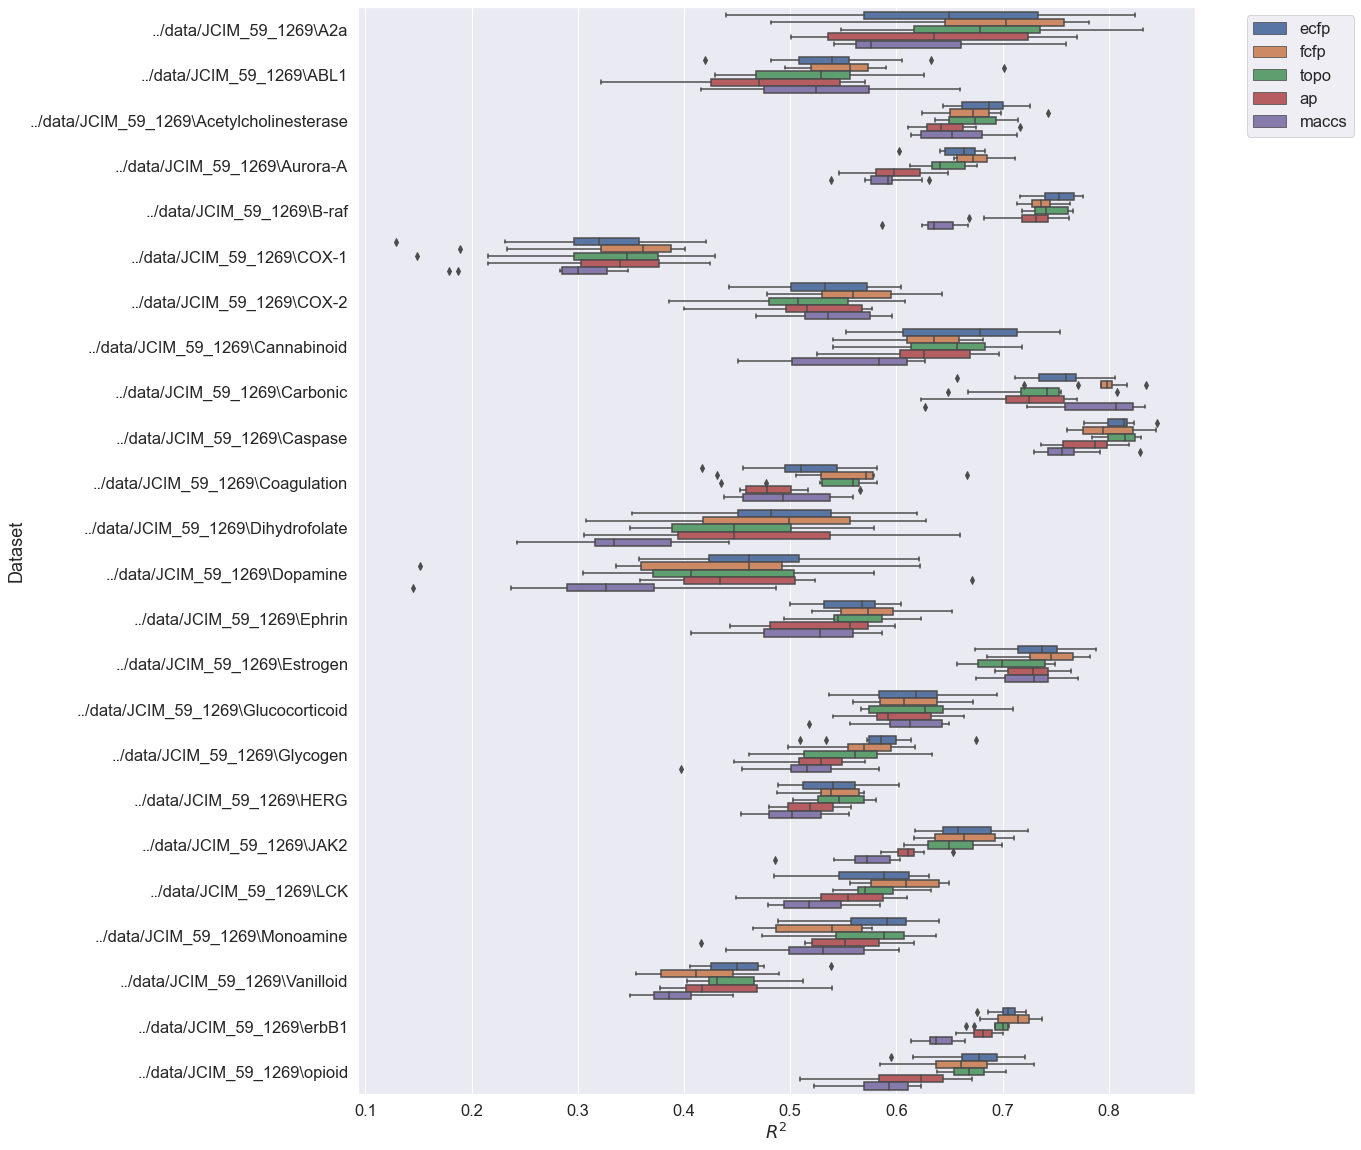

In [17]:
sns.set(rc={'figure.figsize': (15, 20)})
sns.set(font_scale=1.5)
ax = sns.boxplot(y="dataset", x="r2", hue="method", orient="h", data=melt_df, order=sorted(melt_df.dataset.unique()))
ax.set(ylabel="Dataset", xlabel="$R^2$")
_ = ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1)

In [18]:
cohen_list = []
for k,v in result_df.groupby("dataset"):
    delta = v.ecfp - v.fcfp
    cohen_list.append([k,np.mean(delta)/np.std(delta)])
cohen_df = pd.DataFrame(cohen_list,columns=["dataset","cohen_d"])

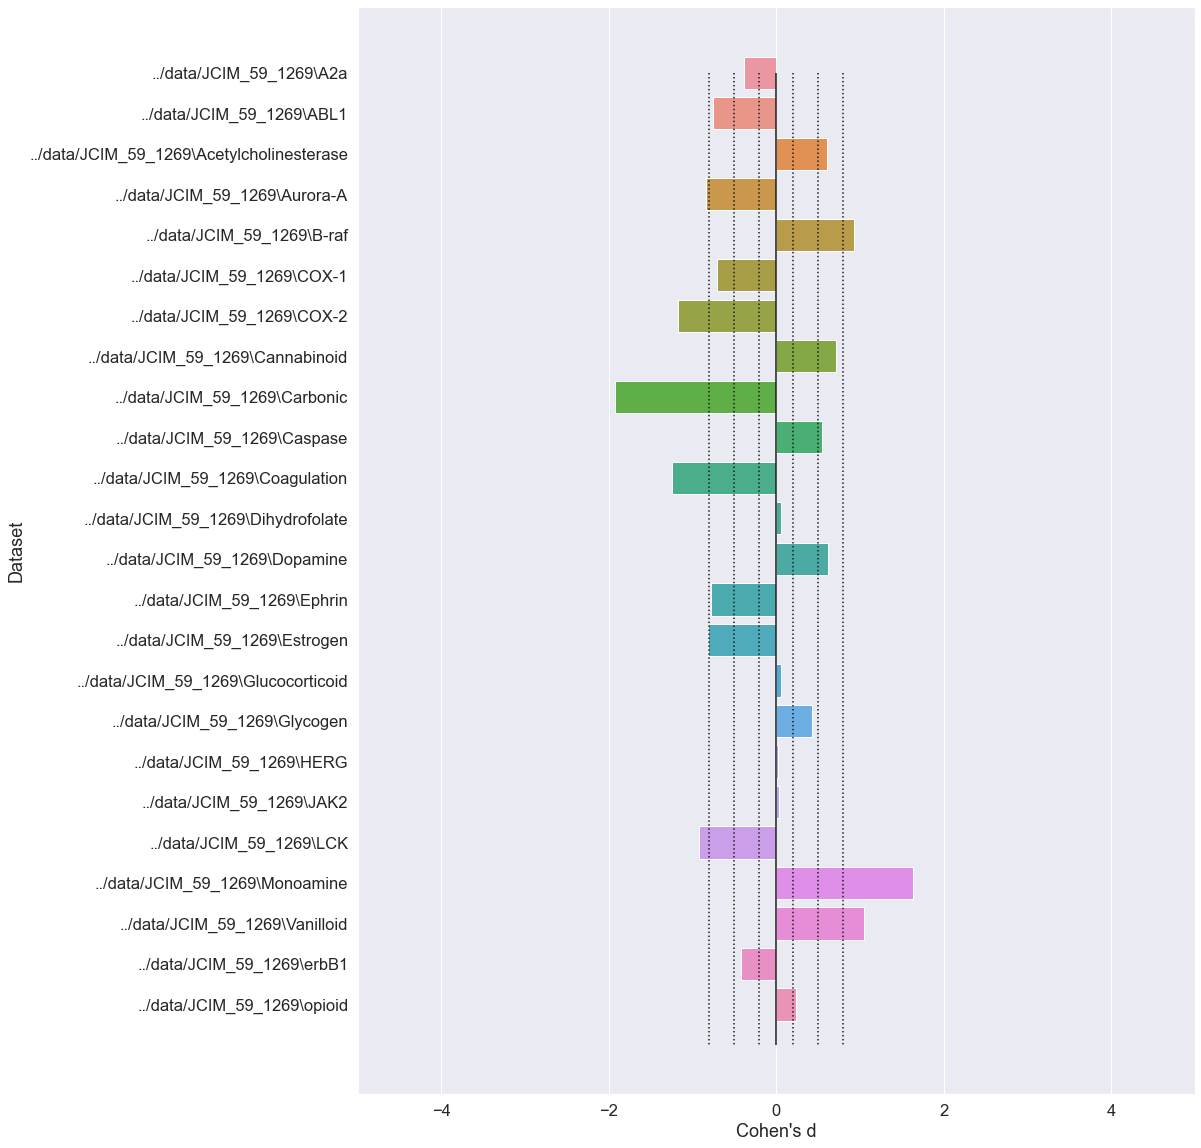

In [19]:
ax = sns.barplot(y="dataset", x="cohen_d", data=cohen_df, orient="h")
ax.set(ylabel="Dataset", xlabel="Cohen's d")
_ = ax.set(xlim=[-5,5])
ax.vlines(0, 0, cohen_df.shape[0], linestyles="solid")
for i in [-0.8,-0.5,-0.2,0.2,0.5,0.8]:
    ax.vlines(i, 0, cohen_df.shape[0], linestyles = "dotted")